# Introduction

In this project, we aim to predict stock movements based on social media sentiment, particularly from Reddit discussions. The stock market is influenced by a wide array of factors, including social media discussions, investor sentiment, and public opinion. Social media platforms like Reddit, especially subreddits dedicated to finance and investing, have become valuable sources of real-time information that can provide insights into stock price movements.

### Objective

The goal of this project is to build a machine learning model that predicts stock price movements (either "up" or "down") by analyzing the sentiment and content of user-generated posts on Reddit. Specifically, we will focus on the **Tesla (TSLA)** stock, extracting and processing data from Reddit to capture discussions, predictions, and sentiments expressed by users.

### Steps Involved

1. **Data Scraping**: We will collect data from Reddit, focusing on relevant discussions around Tesla stock. Using the PRAW (Python Reddit API Wrapper), we will scrape posts and comments from subreddits such as `r/stocks` and `r/investing`.
   
2. **Data Preprocessing**: The scraped data will be cleaned and preprocessed, including the removal of noise and irrelevant information, handling missing data, and structuring it in a format suitable for machine learning.

3. **Sentiment Analysis**: We will analyze the sentiment of each post and comment using Natural Language Processing (NLP) techniques to determine whether the sentiment is positive, negative, or neutral towards Tesla stock.

4. **Feature Engineering**: We will extract relevant features, such as sentiment polarity, the frequency of mentions, and the type of discussions, which will be used to train the machine learning model.

5. **Model Development**: A machine learning model will be built to predict the movement of Tesla stock. The model will be trained on the processed data and evaluated on its prediction accuracy.

6. **Evaluation**: We will evaluate the model’s performance using metrics like accuracy, precision, recall, and F1-score.

### Tools and Technologies

- **Reddit API (PRAW)**: To scrape data from Reddit.
- **Python**: The programming language used for data processing, analysis, and machine learning.
- **Natural Language Processing (NLP)**: To analyze sentiment in text data.
- **Machine Learning Libraries**: Scikit-learn, TensorFlow, or PyTorch for building and training the model.
- **Jupyter Notebook**: For interactive development and documentation.

### Why This Project?

The prediction of stock movements based on social media sentiment is an emerging area in the field of financial analytics and machine learning. By analyzing discussions around stocks like Tesla, we can gain valuable insights into investor sentiment, which can be a powerful predictor of stock price trends. This project will not only help in understanding market behavior but also demonstrate the application of machine learning in the finance domain.

---

This project is intended to demonstrate the process of collecting, preprocessing, and analyzing social media data, applying sentiment analysis, and building a prediction model to forecast stock movements.


# Data Scraping


In [3]:
# importing libraries
import praw
import pandas as pd
from datetime import datetime
import time
import random
import os

In [ ]:
# Connect to Reddit using PRAW 
reddit = praw.Reddit(
    client_id="your-id",      
    client_secret="your-key",  
    user_agent="StockSentimentAnalysis"  
)

In [56]:
# Defining subreddits to scrape data from 
subreddits = ["TeslaMotors", "stocks", "investing", "stockmarket", "financialindependence", "finance", "WallStreetBets", "trading"]

# Define relevant keywords to filter Tesla-related posts 
keywords = ["Tesla", "TSLA", "Elon Musk", "stock prediction", "Tesla stock", "Vehicle Data", "TeslaFi", "Full Self-Driving", "Model 3", "Cybertruck"]



In [57]:
# File to save progress incrementally
output_file = "reddit_stock_data.csv"

# Load existing data if restarting
if os.path.exists(output_file):
    existing_data = pd.read_csv(output_file)
    scraped_ids = set(existing_data["ID"].tolist())  # Track previously scraped IDs
    all_data = existing_data.to_dict(orient="records")
else:
    scraped_ids = set()
    all_data = []

# Function to scrape posts and comments
def scrape_reddit(subreddit, limit=500, time_filter="year"):
    data = []
    try:
        subreddit_instance = reddit.subreddit(subreddit)
        for submission in subreddit_instance.top(time_filter=time_filter, limit=limit):
            if submission.id not in scraped_ids:  # Check for duplicates
                # Filter posts by keywords
                if any(keyword in submission.title for keyword in keywords):
                    post_text = submission.title + " " + submission.selftext.strip()
                    if post_text.strip():  # Ensure non-empty content
                        data.append({
                            "ID": submission.id,
                            "Post/Comment": "Post",
                            "Text": post_text,
                            "Score": submission.score,
                            "Num_Comments": submission.num_comments,
                            "Timestamp": datetime.fromtimestamp(submission.created_utc),
                            "URL": submission.url
                        })
                        scraped_ids.add(submission.id)

                # Scrape comments
                submission.comments.replace_more(limit=0)
                for comment in submission.comments.list():
                    if comment.id not in scraped_ids:
                        if any(keyword in comment.body for keyword in keywords):
                            comment_text = comment.body.strip()
                            if comment_text:  # Ensure non-empty content
                                data.append({
                                    "ID": comment.id,
                                    "Post/Comment": "Comment",
                                    "Text": comment_text,
                                    "Score": comment.score,
                                    "Num_Comments": 0,  # Comments don't have nested comments
                                    "Timestamp": datetime.fromtimestamp(comment.created_utc),
                                    "URL": submission.url
                                })
                                scraped_ids.add(comment.id)

        return data
    except Exception as e:
        print(f"Error scraping {subreddit}: {e}")
        return []




In [58]:
# Main scraping loop
for subreddit in subreddits:
    print(f"Scraping data from subreddit: {subreddit}...")
    scraped_data = scrape_reddit(subreddit)
    all_data.extend(scraped_data)
    
    # Incremental saving to avoid data loss
    df = pd.DataFrame(all_data)
    df.drop_duplicates(subset=["ID"], inplace=True)  # Ensure unique rows
    df.to_csv(output_file, index=False)
    print(f"Data saved. Current total: {len(df)} rows.")
    time.sleep(random.uniform(2, 5))  # Add random delay to avoid API rate limits

print(f"Scraping complete. Final dataset saved to '{output_file}'.")

Scraping data from subreddit: TeslaMotors...
Data saved. Current total: 16376 rows.
Scraping data from subreddit: stocks...
Data saved. Current total: 22341 rows.
Scraping data from subreddit: investing...
Data saved. Current total: 23554 rows.
Scraping data from subreddit: stockmarket...
Data saved. Current total: 24777 rows.
Scraping data from subreddit: financialindependence...
Data saved. Current total: 24876 rows.
Scraping data from subreddit: finance...
Data saved. Current total: 24903 rows.
Scraping data from subreddit: WallStreetBets...
Data saved. Current total: 27945 rows.
Scraping data from subreddit: trading...
Data saved. Current total: 28012 rows.
Scraping complete. Final dataset saved to 'reddit_stock_data.csv'.


In [8]:
# Set the display option to show the entire text in columns
pd.set_option('display.max_colwidth', None)
df = pd.read_csv('reddit_stock_data.csv')
df.head()

,ID,Post/Comment,Text,Score,Num_Comments,Timestamp,URL
0,1csxugp,Post,Tesla billionaire investor votes against restoring Elon Musk’s $50 billion pay package,18279,1113,2024-05-16 04:05:15,https://www.forbes.com.au/news/innovation/teslas-top-retail-investor-votes-against-restoring-elon-musks-50-billion-pay-package/
1,l484wkv,Comment,"[First and foremost, please read r/TeslaMotors - A New Dawn](https://www.reddit.com/r/teslamotors/comments/1c49sv0/rteslamotors_a_new_dawn/)\n\n\nAs we are not a support sub, please make sure to use the proper resources if you have questions: [Official Tesla Support](https://www.tesla.com/support), [r/TeslaSupport](https://www.reddit.com/r/TeslaSupport/) | [r/TeslaLounge](https://www.reddit.com/r/TeslaLounge/) personal content | [Discord Live Chat](https://discord.gg/tesla) for anything.\n\n\n*I am a bot, and this action was performed automatically. Please [contact the moderators of this subreddit](/message/compose/?to=/r/teslamotors) if you have any questions or concerns.*",1,0,2024-05-16 04:05:15,https://www.forbes.com.au/news/innovation/teslas-top-retail-investor-votes-against-restoring-elon-musks-50-billion-pay-package/
2,l4986ag,Comment,"Leo Koguan's percentage ownership in Tesla is approximately 0.9% as of May 2024, based on his reported ownership of about 27.6 million shares out of the 3,186,000,000 shares outstanding.",159,0,2024-05-16 08:40:25,https://www.forbes.com.au/news/innovation/teslas-top-retail-investor-votes-against-restoring-elon-musks-50-billion-pay-package/
3,l49ayrc,Comment,"> Restoring Musk’s stock-based package “means he will continue to be driven to innovate and drive growth at Tesla because the value of his shares will depend on it!” she said in its recent proxy filing with the SEC.\n\nI’m so sick of this tripe. It’s nonsense. If the CEO *requires* a massive stock-based package in order to be driven to innovate and drive growth at the company they’re leading *in addition to* their already sizable base comp, then they shouldn’t be CEO. Period. I don’t care who you are.",28,0,2024-05-16 09:02:39,https://www.forbes.com.au/news/innovation/teslas-top-retail-investor-votes-against-restoring-elon-musks-50-billion-pay-package/
4,l48h7sf,Comment,"Elon is killing the Tesla brand. They need to keep this from him to send him a big message.\n\nI used to be a long term investor but his childish antics turned me off to the point that I passed on even buying a Tesla. \n\nI just don’t trust him, so I don’t trust the company or the cars that are produced.",123,0,2024-05-16 05:30:14,https://www.forbes.com.au/news/innovation/teslas-top-retail-investor-votes-against-restoring-elon-musks-50-billion-pay-package/


In [9]:
# shape of the dataframe
df.shape

(28012, 7)

In [10]:
# Top 5 rows
df.sample(20)

,ID,Post/Comment,Text,Score,Num_Comments,Timestamp,URL
12154,ksx855f,Comment,"Given that Supercharger locations are very rarely full, and that Tesla is enabling non-Tesla charging at less busy locations, this makes sense. If they tell people to do this, they can charge and everyone knows this is what Tesla said to do.",1,0,2024-03-02 04:21:52,https://driveteslacanada.ca/news/tesla-tells-ford-ev-owners-to-occupy-multiple-superchargers-in-order-to-be-able-to-plug-in/
12996,kpqiu62,Comment,Would adaptive headlights allow for turning afs? Lights that light to the side your are turning? I sorely miss that from older Tesla,2,0,2024-02-10 09:11:05,https://driveteslacanada.ca/news/tesla-approved-to-deploy-adaptive-headlight-feature-to-model-s-and-model-x-in-europe/
10674,kd88k3u,Comment,"As a two Tesla owner, I agree with this. Tesla's Full Self Driving isn't Full Self Driving.",14,0,2023-12-14 02:18:49,https://www.notateslaapp.com/news/1820/dmv-says-teslas-full-self-driving-name-is-false-advertising-tesla-responds
3409,lw4u2u9,Comment,"It will still create an environment where Tesla is the only viable EV carrier out there. Shit he can probably create ways to get kickbacks for his companies but exclude others as “government contracts” or some shit. \nPoint is, he is going to benefit and so will his stockholders.",-1,0,2024-11-09 01:25:08,https://i.redd.it/5ok1enlonpzd1.jpeg
5654,l9473bn,Comment,"I waited until smt like this happens. It makes sense, but nothing of this magnitude happened yet for Tesla.",0,0,2024-06-18 11:19:01,https://www.pcmag.com/news/irreparable-harm-tesla-sues-ex-supplier-for-stealing-1-billion-battery
3854,l00xejg,Comment,"The stock options in the CEO compensation package cost Tesla 2.6 billion. The other 53.4 billion is the theoretical value that was assigned to them by shareholders at the height of the helicopter money in late 2021. 2.6 billion is still a lot of compensation, but it isn't insane... Basically 4x Tim cooks compensation assuming Tim makes 60 mil over the 10 year period. If Tim took that 60 mil in 2018 Apple shares, he would have a much greater theoretical net worth than Elon right now😂",0,0,2024-04-18 00:05:18,https://www.cnn.com/2024/04/17/business/tesla-shareholders-musk-pay-package/index.html
26805,lrk0l2d,Comment,Timing suggests op loaded OTM Tesla calls Thursday before close,4,0,2024-10-12 17:52:37,https://i.redd.it/n0hjh0xjz7ud1.jpeg
2754,kdk43uh,Comment,I own a 2017 S with 200k miles. Original brakes battery and motors. Talked with Tesla about cost of these replacement; they are not needed yet. What is your data? Sounds like maybe envy. It's not too late to get a Tesla. I would recommend a model 3 LR for lowest TCO,2,0,2023-12-16 07:48:05,https://insideevs.com/news/699413/highest-mileage-tesla-model-s-3-batteries-14-motors/
4262,lnnavcn,Comment,"And I thought the supercharger was the big one . . .\n\nNext up, the Gigacharger for charging Tesla airplanes.",6,0,2024-09-18 04:13:21,https://x.com/SawyerMerritt/status/1836073856802447646
23154,kr369v9,Comment,"If everyone is saying it’s Tesla, then certainly it may not.",13,0,2024-02-19 08:55:53,https://www.reddit.com/r/investing/comments/1au7nno/which_magnificent_seven_companyies_do_you_think/


# Data Preprocessing and Cleaning

In [11]:
# importing libraries for data preprocessing
import pandas as pd
import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

tesla = df.drop(['ID', 'URL', 'Post/Comment'], axis=1).copy()
tesla.head()

,Text,Score,Num_Comments,Timestamp
0,Tesla billionaire investor votes against restoring Elon Musk’s $50 billion pay package,18279,1113,2024-05-16 04:05:15
1,"[First and foremost, please read r/TeslaMotors - A New Dawn](https://www.reddit.com/r/teslamotors/comments/1c49sv0/rteslamotors_a_new_dawn/)\n\n\nAs we are not a support sub, please make sure to use the proper resources if you have questions: [Official Tesla Support](https://www.tesla.com/support), [r/TeslaSupport](https://www.reddit.com/r/TeslaSupport/) | [r/TeslaLounge](https://www.reddit.com/r/TeslaLounge/) personal content | [Discord Live Chat](https://discord.gg/tesla) for anything.\n\n\n*I am a bot, and this action was performed automatically. Please [contact the moderators of this subreddit](/message/compose/?to=/r/teslamotors) if you have any questions or concerns.*",1,0,2024-05-16 04:05:15
2,"Leo Koguan's percentage ownership in Tesla is approximately 0.9% as of May 2024, based on his reported ownership of about 27.6 million shares out of the 3,186,000,000 shares outstanding.",159,0,2024-05-16 08:40:25
3,"> Restoring Musk’s stock-based package “means he will continue to be driven to innovate and drive growth at Tesla because the value of his shares will depend on it!” she said in its recent proxy filing with the SEC.\n\nI’m so sick of this tripe. It’s nonsense. If the CEO *requires* a massive stock-based package in order to be driven to innovate and drive growth at the company they’re leading *in addition to* their already sizable base comp, then they shouldn’t be CEO. Period. I don’t care who you are.",28,0,2024-05-16 09:02:39
4,"Elon is killing the Tesla brand. They need to keep this from him to send him a big message.\n\nI used to be a long term investor but his childish antics turned me off to the point that I passed on even buying a Tesla. \n\nI just don’t trust him, so I don’t trust the company or the cars that are produced.",123,0,2024-05-16 05:30:14


In [12]:
tesla.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28012 entries, 0 to 28011
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Text          28012 non-null  object
 1   Score         28012 non-null  int64 
 2   Num_Comments  28012 non-null  int64 
 3   Timestamp     28012 non-null  object
dtypes: int64(2), object(2)
memory usage: 875.5+ KB


In [13]:
# check for duplicates 
tesla.duplicated(subset=['Text']).sum()

np.int64(452)

In [14]:
# descriptive statistics
tesla.describe(include='O')

,Text,Timestamp
count,28012,28012
unique,27560,27755
top,"As we are not a support sub, please make sure to use the proper resources if you have questions: Our Stickied Community Q&A Post, [Official Tesla Support](https://www.tesla.com/support), [r/TeslaSupport](https://www.reddit.com/r/TeslaSupport/) | [r/TeslaLounge](https://www.reddit.com/r/TeslaLounge/) personal content | [Discord Live Chat](https://discord.gg/tesla) for anything.\n\n\n*I am a bot, and this action was performed automatically. Please [contact the moderators of this subreddit](/message/compose/?to=/r/teslamotors) if you have any questions or concerns.*",2024-04-12 05:49:17
freq,124,2


In [15]:
# drop duplicates 
tesla = tesla.drop_duplicates(subset=['Text'], keep='first').reset_index(drop=True)

In [16]:
tesla.duplicated().sum()

np.int64(0)

In [17]:
# checking for missing values 
tesla.isnull().sum()

Text            0
Score           0
Num_Comments    0
Timestamp       0
dtype: int64

In [18]:
# convert Timestamp to datetime object 
tesla['Timestamp'] = pd.to_datetime(tesla['Timestamp'])
tesla.dtypes

Text                    object
Score                    int64
Num_Comments             int64
Timestamp       datetime64[ns]
dtype: object

In [19]:
# Reset the index
tesla = tesla.reset_index(drop=True)

In [49]:
# raw text cleaning
import re
from nltk.corpus import stopwords
import nltk
nltk.data.path.append("C:/Users/91965/AppData/Roaming/nltk_data")
from nltk.stem import WordNetLemmatizer 
from nltk.tokenize import word_tokenize

# Download required NLTK resources if you haven't already
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt_tab')
stop_words = set(stopwords.words('english'))

stop_words.update(set(['musk', 'tesla', 'company', 'people', 'elon']))



[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\91965\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\91965\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\91965\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\91965\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [50]:

# Initialize lemmatizer
lemmatizer = WordNetLemmatizer()

# Text cleaning function
def clean_text(text):
    # Remove URLs
    text = re.sub(r'http\S+|www\S+', '', text)
    
    # Remove special characters and digits
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    
    # Convert to lowercase
    text = text.lower()
    
    # Tokenization
    text = word_tokenize(text)
    
    # Remove stopwords 
    text = [word for word in text if word not in stop_words]
    
    # Remove consecutive duplicate words
    text = [text[i] for i in range(len(text)) if i == 0 or text[i] != text[i - 1]]
    
    # Lemmatization
    text = [lemmatizer.lemmatize(word) for word in text]
    
    # Join the words back into a single string
    text = " ".join(text)
    
    # Remove extra spaces
    text = re.sub(r'\s+', ' ', text).strip()

    return text



In [51]:
# Applying text cleaning
tesla["Cleaned_Text"] = tesla["Text"].apply(clean_text)


In [52]:
tesla[["Text", "Cleaned_Text"]].sample(20)

,Text,Cleaned_Text
6315,"In reply to your edit, the people who come up to you saying they would never buy a Tesla because of Elon are a tiny but vocal minority I suspect they are dwarfed by the people who support Musk + the people who just don’t care about him and choose cars cuz of the cars themselves",reply edit come saying would never buy tiny vocal minority suspect dwarfed support dont care choose car cuz car
23016,"> I seem to keep running into people who just don’t like Musk and I’m trying to separate the hate from what the stock could potentially do.\n\nIf you are specifically calling people out on hating Musk and that clouding their judgement, what exactly do you call this?\n\n> but couldn’t he consolidate other things he’s working on under Tesla in the future?\n\nWhat other things is Elon working under that he could consolidate under Tesla to justify Tesla's insane evaluation? Everything else he works on is very low profit margin business. Twitter is about the only thing that has POTENTIAL to be high profit margin, because it's mostly software, but that isn't going so well.\n\nMy point is that, you seem to be pointing out to people that they hate Elon and therefore are not fit to have an objective discussion about his businesses, yet you seem to be doing the exact same thing but with opposite bias and assuming that Elon somehow elevates the businesses beyond it's economic fundamentals... \n\nDo you not see the problem with your line of questions/reasoning? You are not entering this discussion in good faith either.",seem keep running dont like im trying separate hate stock could potentially specifically calling hating clouding judgement exactly call couldnt consolidate thing he working future thing working could consolidate justify tesla insane evaluation everything else work low profit margin business twitter thing potential high profit margin mostly software isnt going well point seem pointing hate therefore fit objective discussion business yet seem exact thing opposite bias assuming somehow elevates business beyond economic fundamental see problem line questionsreasoning entering discussion good faith either
8458,>There's really nothing separating Tesla from the other EVs these days\n\nSure there is: a subjectively toxic CEO that's regularly alienating political party members that are most likely to be his primary demographic. \n\nI'm not saying it's a large fraction but it's definitely non-zero.,there really nothing separating ev day sure subjectively toxic ceo thats regularly alienating political party member likely primary demographic im saying large fraction definitely nonzero
22688,People get confused.\n\n*Funds* have a hard time beating an index fund. \n\nNo one really knows how well individual investors do because there's nowhere you can actually find that data. \n\nBut clearly someone who has help Apple or MS or Tesla or NVDA for the past 10 years will have handily beat the market by a decent amount. \n\nThe problem with these holding is that they aren't diversified. Which is often why people buy funds. Which tend to underperform the index.,get confused fund hard time beating index fund one really know well individual investor there nowhere actually find data clearly someone help apple m nvda past year handily beat market decent amount problem holding arent diversified often buy fund tend underperform index
17605,Much more like can be bullish instead of being bullish for sure.\n\n\nIt's clear the read here is that this means TSLA won't grow.,much like bullish instead bullish sure clear read mean tsla wont grow
1026,He doesn't own Tesla outright. Unless X is paying a premium for the slot he is robbing Tesla shareholders for his personal benefit.,doesnt outright unless x paying premium slot robbing shareholder personal benefit
6743,🤷‍♂️ tbh 2022 was an insane time - Tesla honored pre orders and sold cars for $15-20k less than what current market rate was; for example people buying model Ys that were preordere

## Simple Topic Identification

In [53]:
from collections import Counter 

In [54]:
# Function to perform topic identification (most common words)
def identify_topics(text):
    # Tokenize the text
    tokens = word_tokenize(text)
    # Count word frequencies
    word_counts = Counter(tokens)
    # Return the most common word(s) in the text
    return word_counts.most_common(1)

In [55]:

def get_topics_from_column(df, column_name):
    # Apply the identify_topics function to the text column
    topics = df[column_name].apply(identify_topics)
    return topics

# Example usage (assuming 'tesla' is your dataframe and it has a 'Text' column)
topics = get_topics_from_column(tesla, 'Cleaned_Text')

In [56]:
topics.head(20)

0     [(billionaire, 1)]
1          [(please, 3)]
2       [(ownership, 2)]
3      [(stockbased, 2)]
4            [(dont, 2)]
5            [(good, 2)]
6            [(year, 2)]
7     [(shareholder, 1)]
8           [(since, 2)]
9            [(good, 1)]
10            [(pay, 2)]
11           [(make, 1)]
12           [(like, 1)]
13          [(apple, 2)]
14     [(surprising, 1)]
15           [(even, 1)]
16            [(lot, 1)]
17          [(tesla, 2)]
18             [(ev, 4)]
19     [(ironically, 1)]
Name: Cleaned_Text, dtype: object

## Add sentiment scores 
Sentiment analysis assigns a polarity score to text. We'll calculate sentiment polarity and add it as a new column. This is critical for stock movement prediction.

In [57]:
from textblob import TextBlob  

# Calculate sentiment polarity
tesla["Sentiment_Polarity"] = tesla["Cleaned_Text"].apply(lambda x: TextBlob(x).sentiment.polarity)


In [58]:
tesla[['Cleaned_Text', 'Sentiment_Polarity']].sample(20)

,Cleaned_Text,Sentiment_Polarity
11317,headed logo beast dual logo one could manually add logo fact thats different term branding,0.000000e+00
24934,get lot money manufacture buy carbon credit billion manufacture able sell dont need pay,5.000000e-01
510,one important thing note optional add increased range mile take cargo space rear,4.000000e-01
19074,bro saved let board vote compensation say mil,0.000000e+00
3124,last vote former shareholder divest everything tsla based increasingly erratic selfserving counter productive behavior exhibited ceo still care tesla ostensible mission accelerate transition sustainable energy there responsible coherent ethical leader place bound rule law fiduciary constraint wont touch stock,1.800000e-01
993,missing whole point chip property cant say hey im going borrow cause using ill pay back month happens supply disruption february slow unforseen event affect secondthird order would manage plus could considered competitor would third party paid premium chip made better deal dont know edit add going add legal expense someone going class action as,-3.083953e-18
16987,need give stock option,0.000000e+00
12762,worth better part trillion dollar make car every minute,4.000000e-01
25285,see cant think moral become politician think like regulator ill approve tesla robotaxis first enough lobbying,-6.250000e-02
21662,still wont stop stock death spiral,0.000000e+00


## Add Time-Based Features
Stock trends are time-sensitive, so we’ll extract useful features like:

 - Day of the week

 - Hour of the day

 - Whether the post/comment was made on a weekend

In [59]:
# Extract time-based features
tesla["Day_of_Week"] = tesla["Timestamp"].dt.day_name()
tesla["Hour_of_Day"] = tesla["Timestamp"].dt.hour
tesla["Is_Weekend"] = tesla["Day_of_Week"].isin(["Saturday", "Sunday"])


In [60]:
tesla[["Timestamp", "Day_of_Week", "Hour_of_Day", "Is_Weekend"]].sample(5)

,Timestamp,Day_of_Week,Hour_of_Day,Is_Weekend
4486,2024-07-08 02:02:19,Monday,2,False
18527,2024-03-29 06:39:06,Friday,6,False
23105,2024-04-09 16:27:12,Tuesday,16,False
27515,2024-07-08 03:19:33,Monday,3,False
18270,2024-04-06 05:57:28,Saturday,5,True


## Exploratory Data Analysis (EDA)
This step helps uncover patterns and relationships in the data that are crucial for feature engineering and model input.

### Task 1: Distribution of Sentiment Polarity
Understand the sentiment polarity in the dataset. This will show whether the content is generally positive, negative, or neutral.

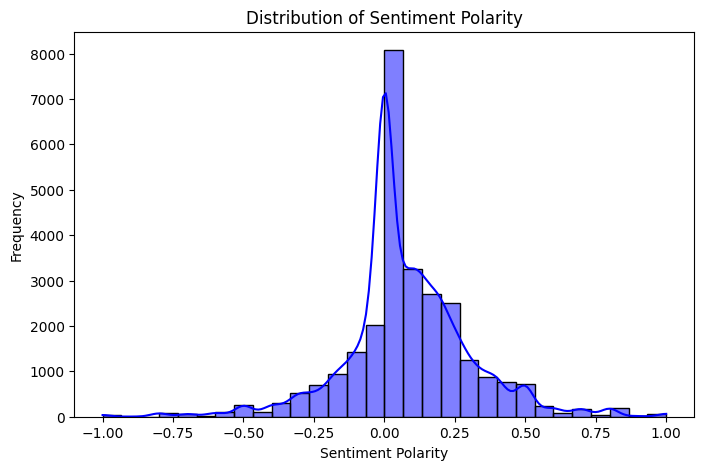

In [61]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot sentiment polarity distribution
plt.figure(figsize=(8, 5))
sns.histplot(tesla["Sentiment_Polarity"], bins=30, kde=True, color='blue')
plt.title("Distribution of Sentiment Polarity")
plt.xlabel("Sentiment Polarity")
plt.ylabel("Frequency")
plt.show()


### Task 2: Sentiment Over Time
Analyze how sentiment trends over time. This can reveal patterns, such as specific days with spikes in sentiment.



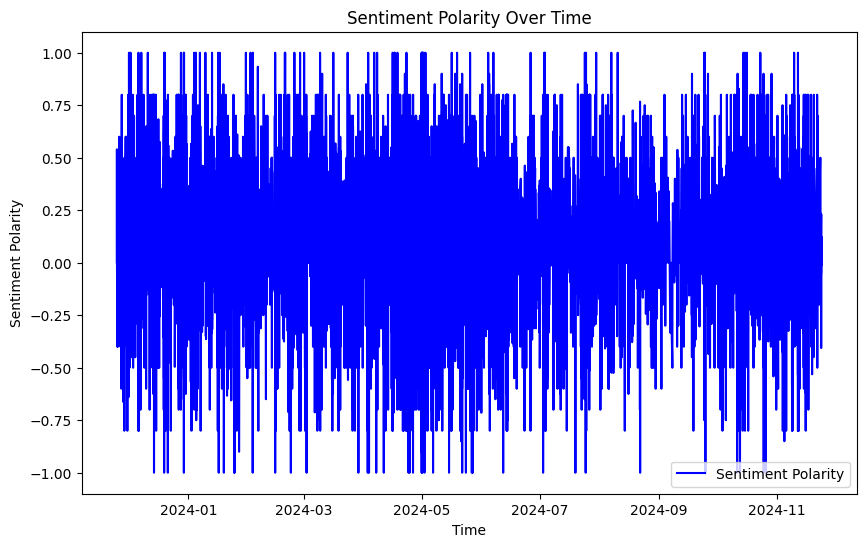

In [62]:
# Plot sentiment over time
plt.figure(figsize=(10, 6))
sns.lineplot(data=tesla, x="Timestamp", y="Sentiment_Polarity", label="Sentiment Polarity", color='blue')
plt.title("Sentiment Polarity Over Time")
plt.xlabel("Time")
plt.ylabel("Sentiment Polarity")
plt.legend()
plt.show()


### Task 3: Top Keywords and Mentions
Identify frequently mentioned words or phrases to detect focus areas.

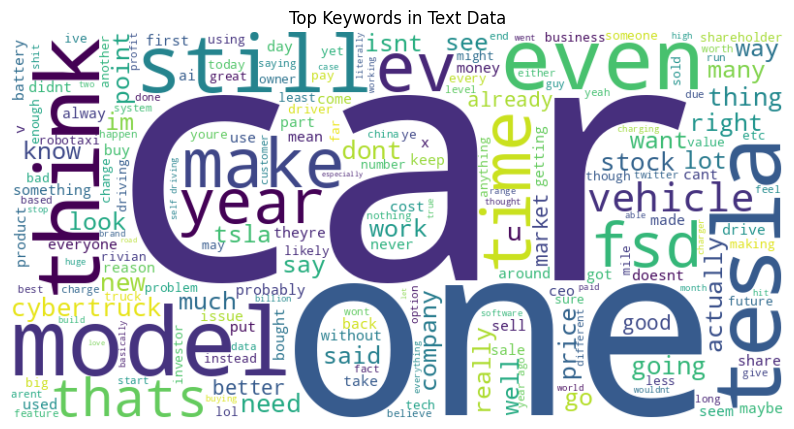

Top 20 Words: [('car', 8826), ('like', 6032), ('would', 5361), ('year', 5304), ('model', 5005), ('dont', 4544), ('get', 4157), ('one', 4054), ('tesla', 3837), ('ev', 3758), ('think', 3678), ('make', 3575), ('even', 3543), ('time', 3434), ('stock', 3359), ('im', 3068), ('also', 2909), ('fsd', 2807), ('vehicle', 2800), ('still', 2782)]


In [63]:
from collections import Counter
from wordcloud import WordCloud

# Combine all cleaned text for word analysis
all_words = ' '.join(tesla["Cleaned_Text"])

# Generate a word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_words)

# Plot the word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Top Keywords in Text Data")
plt.show()

# Top 20 most common words
word_freq = Counter(all_words.split())
print("Top 20 Words:", word_freq.most_common(20))


### Task 4: Sentiment by Day of the Week
Understand if sentiment differs by day to reveal temporal patterns.

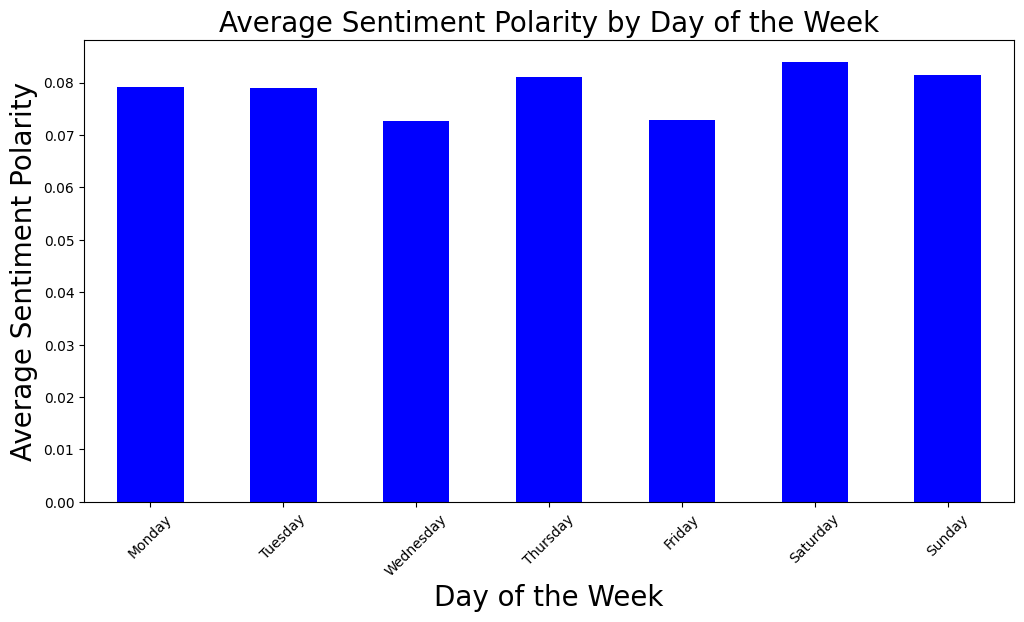

In [70]:
# Average sentiment by day of the week
day_sentiment = tesla.groupby("Day_of_Week")["Sentiment_Polarity"].mean().reindex(
    ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
)

# Plot average sentiment by day
plt.figure(figsize=(12, 6))
day_sentiment.plot(kind="bar", color='blue')
plt.title("Average Sentiment Polarity by Day of the Week", fontsize=20)
plt.xlabel("Day of the Week", fontsize=20)
plt.ylabel("Average Sentiment Polarity", fontsize=20)
plt.xticks(rotation=45)
plt.show()


## Label Creation

In [82]:
import yfinance as yf

# Fetch Tesla stock data for a specific date range
stock_symbol = "TSLA"
start_date = "2023-11-24"  
end_date = "2024-11-24"    

stock_data = yf.download(stock_symbol, start=start_date, end=end_date)

stock_data.head()


[*********************100%***********************]  1 of 1 completed

Price,Adj Close,Close,High,Low,Open,Volume
Ticker,TSLA,TSLA,TSLA,TSLA,TSLA,TSLA
Date,,,,,,
2023-11-24,235.449997,235.449997,238.750000,232.330002,233.750000,65125200
2023-11-27,236.080002,236.080002,238.330002,232.100006,236.889999,112031800
2023-11-28,246.720001,246.720001,247.000000,234.009995,236.679993,148549900
2023-11-29,244.139999,244.139999,252.750000,242.759995,249.210007,135401300
2023-11-30,240.080002,240.080002,245.220001,236.910004,245.139999,132353200


In [86]:
# Flatten the multi-index columns
stock_data.columns = ['_'.join(col).strip() for col in stock_data.columns.values]

# Check the result
stock_data.columns = ['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume']
stock_data.head()


,Adj Close,Close,High,Low,Open,Volume
Date,,,,,,
2023-11-24,235.449997,235.449997,238.750000,232.330002,233.750000,65125200
2023-11-27,236.080002,236.080002,238.330002,232.100006,236.889999,112031800
2023-11-28,246.720001,246.720001,247.000000,234.009995,236.679993,148549900
2023-11-29,244.139999,244.139999,252.750000,242.759995,249.210007,135401300
2023-11-30,240.080002,240.080002,245.220001,236.910004,245.139999,132353200


In [88]:
# Calculate the daily percentage change of the 'Close' price
stock_data['Price_Change'] = stock_data['Close'].pct_change()

# Create the 'Label' based on price change
stock_data['Label'] = 'Stable'  # Default label
stock_data.loc[stock_data['Price_Change'] > 0, 'Label'] = 'Up'   # If price goes up
stock_data.loc[stock_data['Price_Change'] < 0, 'Label'] = 'Down' # If price goes down

# Optional: You can define a threshold for stable price movement
threshold = 0.005  # 0.5% change considered stable

# Assign 'Stable' for small price changes
stock_data.loc[abs(stock_data['Price_Change']) < threshold, 'Label'] = 'Stable'

# Check the data
stock_data[[ 'Close', 'Price_Change', 'Label']].head()


,Close,Price_Change,Label
Date,,,
2023-11-24,235.449997,NaN,Stable
2023-11-27,236.080002,0.002676,Stable
2023-11-28,246.720001,0.045069,Up
2023-11-29,244.139999,-0.010457,Down
2023-11-30,240.080002,-0.016630,Down


In [90]:
stock_data.index = pd.to_datetime(stock_data.index)

In [92]:
# Shift stock_data to get the next day's price
stock_data['Next_Close'] = stock_data['Close'].shift(-1)

stock_data.head()



,Adj Close,Close,High,Low,Open,Volume,Price_Change,Label,Next_Close
Date,,,,,,,,,
2023-11-24,235.449997,235.449997,238.750000,232.330002,233.750000,65125200,NaN,Stable,236.080002
2023-11-27,236.080002,236.080002,238.330002,232.100006,236.889999,112031800,0.002676,Stable,246.720001
2023-11-28,246.720001,246.720001,247.000000,234.009995,236.679993,148549900,0.045069,Up,244.139999
2023-11-29,244.139999,244.139999,252.750000,242.759995,249.210007,135401300,-0.010457,Down,240.080002
2023-11-30,240.080002,240.080002,245.220001,236.910004,245.139999,132353200,-0.016630,Down,238.830002


In [98]:
# Merge stock_data with tesla based on Timestamp (date only)
tesla['Date'] = pd.to_datetime(tesla['Timestamp'].dt.date)
tesla = tesla.merge(stock_data[['Next_Close', 'Close']], left_on='Date', right_index=True, how='left')

In [102]:
tesla.drop('Next_Close_x', axis=1)

,Text,Score,Num_Comments,Timestamp,Cleaned_Text,Sentiment_Polarity,Day_of_Week,Hour_of_Day,Is_Weekend,Date,Next_Close_y,Close
0,Tesla billionaire investor votes against restoring Elon Musk’s $50 billion pay package,18279,1113,2024-05-16 04:05:15,billionaire investor vote restoring musk billion pay package,0.000000,Thursday,4,False,2024-05-16,177.460007,174.839996
1,"[First and foremost, please read r/TeslaMotors - A New Dawn](https://www.reddit.com/r/teslamotors/comments/1c49sv0/rteslamotors_a_new_dawn/)\n\n\nAs we are not a support sub, please make sure to use the proper resources if you have questions: [Official Tesla Support](https://www.tesla.com/support), [r/TeslaSupport](https://www.reddit.com/r/TeslaSupport/) | [r/TeslaLounge](https://www.reddit.com/r/TeslaLounge/) personal content | [Discord Live Chat](https://discord.gg/tesla) for anything.\n\n\n*I am a bot, and this action was performed automatically. Please [contact the moderators of this subreddit](/message/compose/?to=/r/teslamotors) if you have any questions or concerns.*",1,0,2024-05-16 04:05:15,first foremost please read rteslamotors new dawn support sub please make sure use proper resource question official support rteslasupport rteslalounge personal content discord live chat anything bot action performed automatically please contact moderator subredditmessagecomposetorteslamotors question concern,0.160390,Thursday,4,False,2024-05-16,177.460007,174.839996
2,"Leo Koguan's percentage ownership in Tesla is approximately 0.9% as of May 2024, based on his reported ownership of about 27.6 million shares out of the 3,186,000,000 shares outstanding.",159,0,2024-05-16 08:40:25,leo koguans percentage ownership approximately may based reported ownership million share outstanding,0.050000,Thursday,8,False,2024-05-16,177.460007,174.839996
3,"> Restoring Musk’s stock-based package “means he will continue to be driven to innovate and drive growth at Tesla because the value of his shares will depend on it!” she said in its recent proxy filing with the SEC.\n\nI’m so sick of this tripe. It’s nonsense. If the CEO *requires* a massive stock-based package in order to be driven to innovate and drive growth at the company they’re leading *in addition to* their already sizable base comp, then they shouldn’t be CEO. Period. I don’t care who you are.",28,0,2024-05-16 09:02:39,restoring musk stockbased package mean continue driven innovate drive growth value share depend said recent proxy filing sec im sick tripe nonsense ceo requires massive stockbased package order driven innovate drive growth theyre leading addition already sizable base comp shouldnt ceo period dont care,-0.321131,Thursday,9,False,2024-05-16,177.460007,174.839996
4,"Elon is killing the Tesla brand. They need to keep this from him to send him a big message.\n\nI used to be a long term investor but his childish antics turned me off to the point that I passed on even buying a Tesla. \n\nI just don’t trust him, so I don’t trust the company or the cars that are produced.",123,0,2024-05-16 05:30:14,killing brand need keep send big message used long term investor childish antic turned point passed even buying dont trust dont trust car produced,-0.083333,Thursday,5,False,2024-05-16,177.460007,174.839996
...,...,...,...,...,...,...,...,...,...,...,...,...
27555,"Elections are one of the main pivotal events that need to be risk-on. Outsized risk reward all over the place. \n\nIf your bet on MRNA, you’re fucked. If you bet on TSLA you’re golden. If you bought OTM calls on both your TSLA calls should be covering your MRNA losses. But either way it’s a perfect opportunity for high RR plays.",2,0,2024-11-12 00:16:27,election one main pivotal event need riskon outsized risk reward place bet mrna youre fucked bet tsla youre golden bought otm call tsla call covering mrna loss either way perfect opportunity high rr play,0.254444,Tuesday,0,False,2024-11-12,330.239990,328.489990
27556,"Your plan to mix ETFs and individual stocks is sol

In [104]:
tesla['Price_Change'] = tesla['Next_Close_y'] - tesla['Close']
tesla['Price_Movement'] = tesla['Price_Change'].apply(lambda x: 1 if x > 0 else 0)
tesla.head()

,Text,Score,Num_Comments,Timestamp,Cleaned_Text,Sentiment_Polarity,Day_of_Week,Hour_of_Day,Is_Weekend,Date,Next_Close_x,Next_Close_y,Close,Price_Change,Price_Movement
0,Tesla billionaire investor votes against restoring Elon Musk’s $50 billion pay package,18279,1113,2024-05-16 04:05:15,billionaire investor vote restoring musk billion pay package,0.000000,Thursday,4,False,2024-05-16,177.460007,177.460007,174.839996,2.62001,1
1,"[First and foremost, please read r/TeslaMotors - A New Dawn](https://www.reddit.com/r/teslamotors/comments/1c49sv0/rteslamotors_a_new_dawn/)\n\n\nAs we are not a support sub, please make sure to use the proper resources if you have questions: [Official Tesla Support](https://www.tesla.com/support), [r/TeslaSupport](https://www.reddit.com/r/TeslaSupport/) | [r/TeslaLounge](https://www.reddit.com/r/TeslaLounge/) personal content | [Discord Live Chat](https://discord.gg/tesla) for anything.\n\n\n*I am a bot, and this action was performed automatically. Please [contact the moderators of this subreddit](/message/compose/?to=/r/teslamotors) if you have any questions or concerns.*",1,0,2024-05-16 04:05:15,first foremost please read rteslamotors new dawn support sub please make sure use proper resource question official support rteslasupport rteslalounge personal content discord live chat anything bot action performed automatically please contact moderator subredditmessagecomposetorteslamotors question concern,0.160390,Thursday,4,False,2024-05-16,177.460007,177.460007,174.839996,2.62001,1
2,"Leo Koguan's percentage ownership in Tesla is approximately 0.9% as of May 2024, based on his reported ownership of about 27.6 million shares out of the 3,186,000,000 shares outstanding.",159,0,2024-05-16 08:40:25,leo koguans percentage ownership approximately may based reported ownership million share outstanding,0.050000,Thursday,8,False,2024-05-16,177.460007,177.460007,174.839996,2.62001,1
3,"> Restoring Musk’s stock-based package “means he will continue to be driven to innovate and drive growth at Tesla because the value of his shares will depend on it!” she said in its recent proxy filing with the SEC.\n\nI’m so sick of this tripe. It’s nonsense. If the CEO *requires* a massive stock-based package in order to be driven to innovate and drive growth at the company they’re leading *in addition to* their already sizable base comp, then they shouldn’t be CEO. Period. I don’t care who you are.",28,0,2024-05-16 09:02:39,restoring musk stockbased package mean continue driven innovate drive growth value share depend said recent proxy filing sec im sick tripe nonsense ceo requires massive stockbased package order driven innovate drive growth theyre leading addition already sizable base comp shouldnt ceo period dont care,-0.321131,Thursday,9,False,2024-05-16,177.460007,177.460007,174.839996,2.62001,1
4,"Elon is killing the Tesla brand. They need to keep this from him to send him a big message.\n\nI used to be a long term investor but his childish antics turned me off to the point that I passed on even buying a Tesla. \n\nI just don’t trust him, so I don’t trust the company or the cars that are produced.",123,0,2024-05-16 05:30:14,killing brand need keep send big message used long term investor childish antic turned point passed even buying dont trust dont trust car produced,-0.083333,Thursday,5,False,2024-05-16,177.460007,177.460007,174.839996,2.62001,1


In [105]:
tesla[['Timestamp', 'Cleaned_Text', 'Sentiment_Polarity', 'Price_Movement']].head()


,Timestamp,Cleaned_Text,Sentiment_Polarity,Price_Movement
0,2024-05-16 04:05:15,billionaire investor vote restoring musk billion pay package,0.000000,1
1,2024-05-16 04:05:15,first foremost please read rteslamotors new dawn support sub please make sure use proper resource question official support rteslasupport rteslalounge personal content discord live chat anything bot action performed automatically please contact moderator subredditmessagecomposetorteslamotors question concern,0.160390,1
2,2024-05-16 08:40:25,leo koguans percentage ownership approximately may based reported ownership million share outstanding,0.050000,1
3,2024-05-16 09:02:39,restoring musk stockbased package mean continue driven innovate drive growth value share depend said recent proxy filing sec im sick tripe nonsense ceo requires massive stockbased package order driven innovate drive growth theyre leading addition already sizable base comp shouldnt ceo period dont care,-0.321131,1
4,2024-05-16 05:30:14,killing brand need keep send big message used long term investor childish antic turned point passed even buying dont trust dont trust car produced,-0.083333,1


## Feature Engineering

#### Add Time-Based Features:

Extract temporal features like:

 - Hour of the Day

 - Day of the Week

 - Is_Weekend

In [116]:
tesla["Hour"] = tesla["Timestamp"].dt.hour
tesla["Is_Weekend"] = tesla["Day_of_Week"].isin(["Saturday", "Sunday"]).astype(int)

#### Sentiment Aggregation:

Create aggregated sentiment features based on engagement:

Average sentiment per post.
Weighted sentiment (weighted by Score or Num_Comments).

In [117]:
tesla["Weighted_Sentiment"] = tesla["Sentiment_Polarity"] * tesla["Score"]

## Model Selection and Training

In [ ]:
from sklearn.model_selection import train_test_split

# We will use 'Cleaned_Text' and 'Sentiment_Polarity' as features
# 'Price_Movement' will be the target label

X = tesla[['Cleaned_Text', 'Sentiment_Polarity', 'Hour_of_Day', 'Weighted_Sentiment', 'Hour', 'Is_Weekend']]  # Features
y = tesla['Price_Movement']  # Target

# Split data into training and test sets (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Check the shape of train-test splits
X_train.shape, X_test.shape, y_train.shape, y_test.shape


((22048, 6), (5512, 6), (22048,), (5512,))

In [119]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=5000)  # Limit to top 5000 features for performance

# Fit and transform the training data, transform the test data
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train['Cleaned_Text'])
X_test_tfidf = tfidf_vectorizer.transform(X_test['Cleaned_Text'])

# Check the shape of the transformed data
X_train_tfidf.shape, X_test_tfidf.shape


((22048, 5000), (5512, 5000))

In [120]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# Choose model (Logistic Regression or Random Forest)
model = LogisticRegression(max_iter=1000)  # Use Logistic Regression

# Train the model
model.fit(X_train_tfidf, y_train)

# Model predictions on the test data
y_pred = model.predict(X_test_tfidf)

# Check the shape of predictions
y_pred.shape


(5512,)

In [121]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix

# Accuracy score
accuracy = accuracy_score(y_test, y_pred)

# Precision, Recall, F1-Score
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Classification Report
class_report = classification_report(y_test, y_pred)

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Print the evaluation results
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-Score:", f1)
print("\nClassification Report:\n", class_report)
print("\nConfusion Matrix:\n", conf_matrix)


Accuracy: 0.5947024673439768
Precision: 0.4899817850637523
Recall: 0.24321880650994576
F1-Score: 0.32507552870090634

Classification Report:
               precision    recall  f1-score   support

           0       0.62      0.83      0.71      3300
           1       0.49      0.24      0.33      2212

    accuracy                           0.59      5512
   macro avg       0.56      0.54      0.52      5512
weighted avg       0.57      0.59      0.56      5512


Confusion Matrix:
 [[2740  560]
 [1674  538]]


In [122]:
# Example: Trying RandomForestClassifier for potentially better performance
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_tfidf, y_train)

# Make predictions
y_pred_rf = rf_model.predict(X_test_tfidf)

# Evaluate
accuracy_rf = accuracy_score(y_test, y_pred_rf)
precision_rf = precision_score(y_test, y_pred_rf)
recall_rf = recall_score(y_test, y_pred_rf)
f1_rf = f1_score(y_test, y_pred_rf)

# Print Random Forest model evaluation
print("Random Forest - Accuracy:", accuracy_rf)
print("Random Forest - Precision:", precision_rf)
print("Random Forest - Recall:", recall_rf)
print("Random Forest - F1-Score:", f1_rf)


Random Forest - Accuracy: 0.5879898403483309
Random Forest - Precision: 0.4625158831003812
Random Forest - Recall: 0.16455696202531644
Random Forest - F1-Score: 0.24274758252750916


In [ ]:
# Trying NaiveBayesClassifier 
from sklearn.naive_bayes import MultinomialNB
nb_model = MultinomialNB()
nb_model.fit(X_train_tfidf, y_train)

# Make predictions
y_pred_nb= nb_model.predict(X_test_tfidf)

# Evaluate
accuracy_nb = accuracy_score(y_test, y_pred_nb)
precision_nb = precision_score(y_test, y_pred_nb)
recall_nb = recall_score(y_test, y_pred_nb)
f1_nb = f1_score(y_test, y_pred_nb)

# Print Random Forest model evaluation
print("Naive Bayes - Accuracy:", accuracy_nb)
print("Naive Bayes - Precision:", precision_nb)
print("Naive Bayes - Recall:", recall_nb)
print("Naive Bayes - F1-Score:", f1_nb)

Naive Bayes - Accuracy: 0.6008708272859217
Naive Bayes - Precision: 0.5178571428571429
Naive Bayes - Recall: 0.07866184448462929
Naive Bayes - F1-Score: 0.13657770800627944


In [128]:


# Import necessary libraries
from hyperopt import hp, fmin, tpe, Trials, STATUS_OK
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

# Define the objective function for optimization
def objective(params):
    # Create the Naive Bayes model with parameters from the optimization
    nb_model = MultinomialNB(alpha=params['alpha'])
    
    # Fit the model
    nb_model.fit(X_train_tfidf, y_train)
    
    # Make predictions
    y_pred = nb_model.predict(X_test_tfidf)
    
    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    # Return the negative F1 score to minimize (Hyperopt minimizes)
    return {
        'loss': -f1,  # We want to maximize F1, so we return negative F1 for minimization
        'status': STATUS_OK,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

# Define the search space for the hyperparameters
space = {
    'alpha': hp.uniform('alpha', 0.1, 2.0)  # Alpha is the smoothing parameter for MultinomialNB
}

# Initialize trials object to track the optimization process
trials = Trials()

# Perform the optimization
best = fmin(
    fn=objective,  # The objective function to minimize
    space=space,    # The space of hyperparameters to explore
    algo=tpe.suggest,  # Tree of Parzen Estimators algorithm
    max_evals=50,  # Number of iterations
    trials=trials   # Trials object to store the results
)

# Display the best hyperparameters found
print("Best Hyperparameters: ", best)

# Use the best alpha to fit the final model
best_alpha = best['alpha']
final_model = MultinomialNB(alpha=best_alpha)
final_model.fit(X_train_tfidf, y_train)

# Make predictions using the final model
y_pred_final = final_model.predict(X_test_tfidf)

# Evaluate the final model
accuracy_final = accuracy_score(y_test, y_pred_final)
precision_final = precision_score(y_test, y_pred_final)
recall_final = recall_score(y_test, y_pred_final)
f1_final = f1_score(y_test, y_pred_final)

# Print the evaluation of the final model
print("Final Model - Accuracy:", accuracy_final)
print("Final Model - Precision:", precision_final)
print("Final Model - Recall:", recall_final)
print("Final Model - F1-Score:", f1_final)


100%|██████████| 50/50 [00:18<00:00,  2.71trial/s, best loss: -0.20399274047186933]
Best Hyperparameters:  {'alpha': np.float64(0.10335023169262075)}
Final Model - Accuracy: 0.6021407837445574
Final Model - Precision: 0.5174953959484346
Final Model - Recall: 0.12703435804701627
Final Model - F1-Score: 0.20399274047186933
